**Ameya Dehade**

In [11]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr 
import numpy as np

iterations = [
    
#     # 2 year periods
#     ('2022-02-01', '2024-02-01'),
#     ('2020-02-01', '2022-02-01'),
#     ('2018-02-01', '2020-02-01'),
#     ('2016-02-01', '2018-02-01'),
#     ('2014-02-01', '2016-02-01'),
#     ('2012-02-01', '2014-02-01'),
#     ('2010-02-01', '2012-02-01'),
    
#     # 3 year periods
#     ('2021-02-01', '2024-02-01'),
#     ('2018-02-01', '2021-02-01'),
#     ('2015-02-01', '2018-02-01'),
#     ('2012-02-01', '2015-02-01'),
#     ('2010-02-01', '2013-02-01'),
    
#     # 4 year periods
#     ('2020-02-01', '2024-02-01'),
#     ('2016-02-01', '2020-02-01'),
#     ('2012-02-01', '2016-02-01'),
#     ('2010-02-01', '2014-02-01'),
    
#     # 5 year periods
#     ('2019-02-01', '2024-02-01'),
#     ('2014-02-01', '2019-02-01'),
#     ('2010-02-01', '2015-02-01'),
    
#     # 6 year periods
#     ('2018-02-01', '2024-02-01'),
#     ('2012-02-01', '2018-02-01'),
#     ('2010-02-01', '2016-02-01'),
    
#     # 8 year periods
#     ('2016-02-01', '2024-02-01'),
#     ('2010-02-01', '2018-02-01'),
    
    # Entire Period
    ('2010-02-01', '2024-02-01')
]

df = pd.read_csv('IBOVDia_03-04-24.csv')
tickers = df['Code'].values
end = len(tickers) - 2
mySymbols = [s + '.SA' for s in tickers[:end]]

START_DATE = '2010-02-01'
TRUNCATE_DATE = '2011-02-01'
END_DATE = '2024-02-01'

start_date = '2010-02-01'
truncate_date = '2011-02-01'
end_date = '2024-02-01'

priceTablesByTicker = {}

priceTable = pd.read_csv('priceTable.csv', parse_dates=[0])
priceTable.set_index(priceTable.columns[0], inplace=True)

for ticker in mySymbols:
    currTable = pd.read_csv(ticker + '_price_table.csv', parse_dates=[0])
    currTable.set_index(currTable.columns[0], inplace=True)
    priceTablesByTicker[ticker] = currTable
    
#print(priceTablesByTicker['ABEV3.SA'])

In [12]:
def benchmark_strategies(priceTable, start_date, end_date):
    rtn = priceTable.loc[start_date:end_date].pct_change()*100
    truncate_date = pd.to_datetime(start_date) + pd.DateOffset(years=1)
    rtn_prev = rtn.shift(periods = 1)
    df_5d_rolling = rtn_prev.rolling(5).sum()
    df_5d_rolling.dropna(inplace=True, how='all')
    
    mom_sig_raw_arr = []
    mom_sig_raw = rtn.shift(22).rolling(231).sum().dropna(how='all')
    mom_sig_mean = mom_sig_raw.mean(axis = 1)
    mom_sig_std = mom_sig_raw.std(axis = 1)
    mom_sig_norm = mom_sig_raw.sub(mom_sig_mean, axis = 0).div(mom_sig_std, axis = 0)
    
    mom_rtn = (mom_sig_norm/(574-1) * rtn).sum(axis=1)
    mom_rtn_mean = mom_rtn.mean() * 252     
    mom_rtn_std = mom_rtn.std() * 252**0.5
    mom_SR = mom_rtn_mean / mom_rtn_std
    #print(mom_rtn_mean, mom_rtn_std, mom_SR)
    
    mr_sig_raw = - df_5d_rolling
    mr_sig_mean = mr_sig_raw.mean(axis = 1)
    mr_sig_std = mr_sig_raw.std(axis = 1)
    mr_sig_norm = mr_sig_raw.sub(mr_sig_mean, axis = 0).div(mr_sig_std, axis = 0)
    mr_sig_raw.head()
    
    mr_rtn = (mr_sig_norm/(574-1) * rtn).truncate(before=truncate_date).sum(axis=1) #starts 2020
    mr_rtn_mean = mr_rtn.mean() * 252
    mr_rtn_std = mr_rtn.std() * (252**0.5)
    mr_SR = mr_rtn_mean / mr_rtn_std
    #print(mr_rtn_mean, mr_rtn_std, mr_SR)
        
    both_rtn = 0.5*mom_rtn + 0.5*mr_rtn  # This is the return of a 50/50 portfolio of both strategies.
    both_rtn_mean = both_rtn.mean() * 252
    both_rtn_std = both_rtn.std() * 252**0.5
    both_SR = both_rtn_mean / both_rtn_std
    #print(both_rtn_mean, both_rtn_std, both_SR)
    
#     df_factors = pd.concat([mom_rtn, mr_rtn], axis=1)
#     df_factors.columns = ['mom', 'mr']
#     corr_matrix = df_factors.corr()
#     corr_matrix
    
    return mom_rtn.cumsum()/mom_rtn_std*0.15, mr_rtn.cumsum()/mr_rtn_std*0.15, both_rtn.cumsum()/both_rtn_std*0.15, mom_SR, mr_SR, both_SR

In [16]:
def calculate_atr(stock_data, period=14):
    high_low = stock_data['High'] - stock_data['Low']
    high_close = np.abs(stock_data['High'] - stock_data['Close'].shift())
    low_close = np.abs(stock_data['Low'] - stock_data['Close'].shift())
    tr = pd.DataFrame({'high_low': high_low, 'high_close': high_close, 'low_close': low_close}).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

def turtle_atr(stock, atr_period=14, X=2, Y=2):
    #starts 2020
    # Calculate high, low, avg for original turtle strategy
    stock['high'] = stock['Close'].shift(1).rolling(window=5).max()  # 5 day high
    stock['low'] = stock['Close'].shift(1).rolling(window=5).min()   # 5 day low
    stock['avg'] = stock['Close'].shift(1).rolling(window=5).mean()  # 5 day mean

    # Calculate ATR
    stock['ATR'] = calculate_atr(stock, atr_period)

    #og turtle
    stock['long_entry'] = stock['Close'] > stock['high']
    stock['short_entry'] = stock['Close'] < stock['low']
    stock['long_exit'] = stock['Close'] < stock['avg']
    stock['short_exit'] = stock['Close'] > stock['avg']

    stock['positions_long'] = np.nan
    stock.loc[stock['long_entry'], 'positions_long'] = 1
    stock.loc[stock['long_exit'], 'positions_long'] = 0

    stock['positions_short'] = np.nan
    stock.loc[stock['short_entry'], 'positions_short'] = -1
    stock.loc[stock['short_exit'], 'positions_short'] = 0

    
    '''atr stuff (warning: may not work)'''
    #ATR stop loss and new position barrier logic
    stock['long_stop_loss'] = stock['Close'] - (X * stock['ATR'])
    stock['short_stop_loss'] = stock['Close'] + (X * stock['ATR'])
    
        # adj stop loss when a new high/low is reached
    stock['long_stop_loss'] = np.where((stock['Close'] > stock['high']) & (stock['positions_long'] == 1), 
                                       stock['Close'] - (X * stock['ATR']), 
                                       stock['long_stop_loss'])

    stock['short_stop_loss'] = np.where((stock['Close'] < stock['low']) & (stock['positions_short'] == -1), 
                                        stock['Close'] + (X * stock['ATR']), 
                                        stock['short_stop_loss'])

    # sliding stop loss
    stock['long_stop_loss'] = stock['long_stop_loss'].ffill().where(stock['positions_long'] == 1)
    stock['short_stop_loss'] = stock['short_stop_loss'].ffill().where(stock['positions_short'] == -1)

    #exit positions based on stop loss
    stock.loc[stock['Close'] < stock['long_stop_loss'], 'positions_long'] = 0
    stock.loc[stock['Close'] > stock['short_stop_loss'], 'positions_short'] = 0

    #exclusion zones
    stock['long_exclusion_zone'] = stock['Close'] + (Y * stock['ATR'])
    stock['short_exclusion_zone'] = stock['Close'] - (Y * stock['ATR'])
    stock.loc[stock['Close'] < stock['long_exclusion_zone'], 'positions_long'] = 0
    stock.loc[stock['Close'] > stock['short_exclusion_zone'], 'positions_short'] = 0

    #returns
    stock['positions'] = stock['positions_long'].fillna(0) + stock['positions_short'].fillna(0)
    stock['log_returns'] = np.log(stock['Close'] / stock['Close'].shift())
    stock['strategy_returns'] = stock['positions'].shift(1) * stock['log_returns']
    
    return stock['strategy_returns'].cumsum()

def turtle_returns(start_date, end_date, atr_period=14, X=2, Y=2):
    daterange = pd.date_range(start=start_date, end=end_date, freq='D')
    totalret = pd.DataFrame(index=daterange) 
    for stock_ticker in mySymbols:
        totalret[stock_ticker] = turtle_atr(priceTablesByTicker[stock_ticker])    
    #print(totalret['ABEV3.SA'])
    #print(priceTablesByTicker['ABEV3.SA'])
    tt_sig_raw = totalret
    tt_sig_mean = tt_sig_raw.mean(axis = 1)
    tt_sig_std = tt_sig_raw.std(axis = 1)
    tt_sig_norm = tt_sig_raw.sub(tt_sig_mean, axis = 0).div(tt_sig_std, axis = 0)
    
    rtn = priceTable.loc[start_date:end_date].pct_change()*100
    tt_rtn = (tt_sig_norm/(574-1) * rtn).sum(axis=1)
    tt_rtn_mean = tt_rtn.mean() * 252     
    tt_rtn_std = tt_rtn.std() * 252**0.5
    tt_SR = tt_rtn_mean / tt_rtn_std
    # totalret.plot()
    return tt_rtn.cumsum()/tt_rtn.std()*0.15, tt_SR

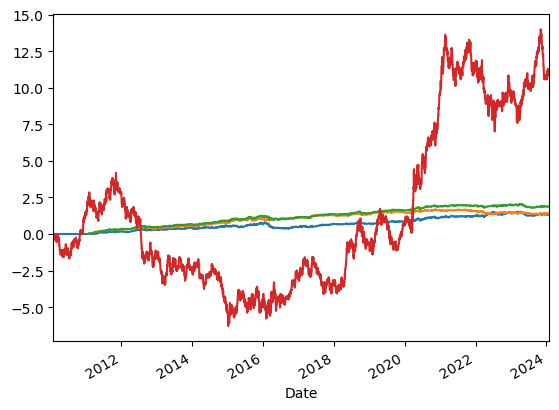

Date Range: 2010-02-01  to  2024-02-01
Sharpe for MoM, MR, and Both: 0.6595117970642579 0.7341320256279831 0.9881135073242865
Sharpe for Turtle: 0.22449476283121667


In [17]:
both_sharpe_map = {}
for i, dates in enumerate(iterations):
    normalized_mom, normalized_mr, normalized_both, mom_sr, mr_sr, both_sr = benchmark_strategies(priceTable, *dates)
    both_sharpe_map[both_sr] = (dates, normalized_mom, normalized_mr, normalized_both, mom_sr, mr_sr)
    normalized_turtle, turtle_sr = turtle_returns(dates[0], dates[1])
    plt.figure()
    normalized_mom.plot() # Blue
    normalized_mr.plot() # Orange
    normalized_both.plot() #Green
    normalized_turtle.plot() # Red
    plt.xlim(dates[0], dates[1])
    plt.show()
    print("Date Range:", dates[0], " to ", dates[1])
    print("Sharpe for MoM, MR, and Both:", mom_sr, mr_sr, both_sr)
    print("Sharpe for Turtle:", turtle_sr)

In [18]:
myKeys = list(both_sharpe_map.keys())
myKeys.sort(reverse=True)
sorted_dict = {i: both_sharpe_map[i] for i in myKeys}

#Sharpe and dates printed in descending order
for i in myKeys:
    print("Combined Sharpe Ratio is ", i, " for dates ", both_sharpe_map[i][0][0], " to ", both_sharpe_map[i][0][1])

Combined Sharpe Ratio is  0.9881135073242865  for dates  2010-02-01  to  2024-02-01
